In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


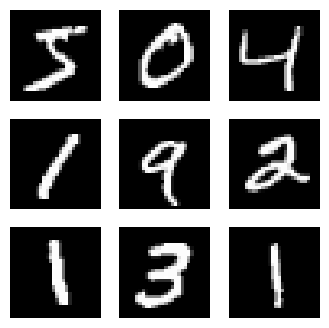

In [ ]:
# Load MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()  # Only need images, not labels

# Reshape and normalize to [-1, 1]
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

# Batch and shuffle
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Visualize a sample
plt.figure(figsize=(4,4))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        # Input: Random noise (100-dim vector)
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Reshape((7, 7, 256)),

        # Upsample to 14x14
        layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Upsample to 28x28
        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Output layer (28x28x1)
        layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = build_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        # Input: 28x28x1 image
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')  # Real/Fake probability
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

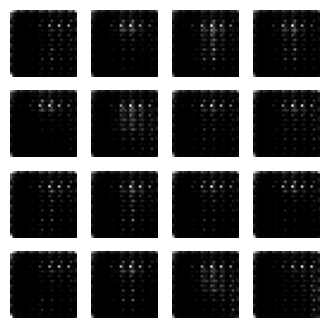

Epoch 1, Gen Loss: 0.9947, Disc Loss: 0.9388, Time: 19.64s


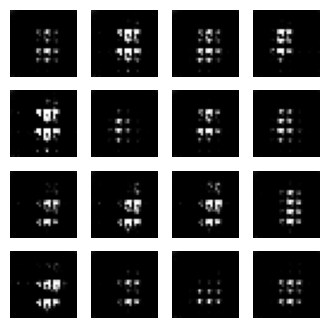

Epoch 2, Gen Loss: 1.1226, Disc Loss: 1.0816, Time: 11.08s


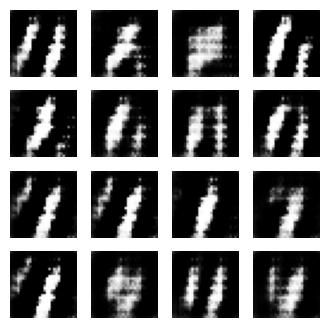

Epoch 3, Gen Loss: 1.0727, Disc Loss: 1.0424, Time: 11.07s


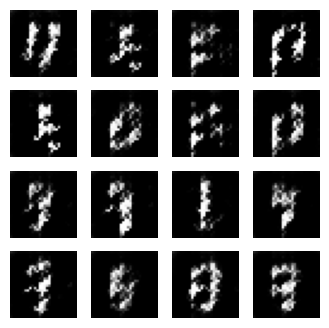

Epoch 4, Gen Loss: 0.9439, Disc Loss: 1.3855, Time: 11.08s


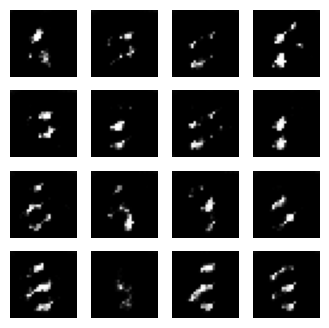

Epoch 5, Gen Loss: 1.2856, Disc Loss: 0.8906, Time: 11.42s


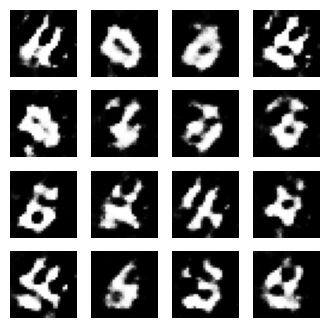

Epoch 6, Gen Loss: 0.8066, Disc Loss: 1.3164, Time: 11.24s


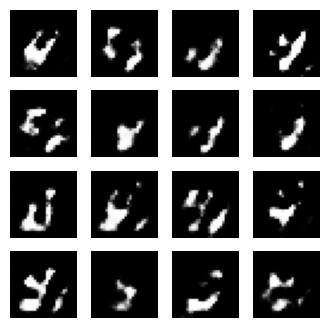

Epoch 7, Gen Loss: 1.0680, Disc Loss: 0.9316, Time: 11.30s


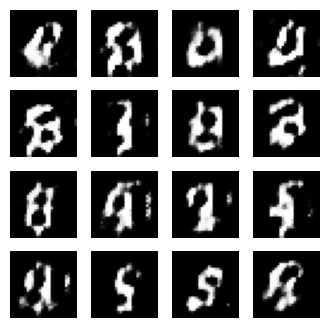

Epoch 8, Gen Loss: 0.8722, Disc Loss: 1.2220, Time: 11.35s


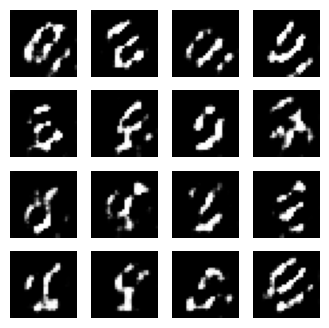

Epoch 9, Gen Loss: 1.1560, Disc Loss: 0.9817, Time: 11.40s


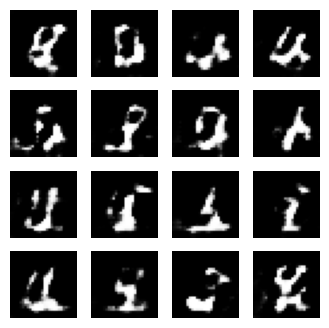

Epoch 10, Gen Loss: 1.1045, Disc Loss: 1.0761, Time: 11.46s


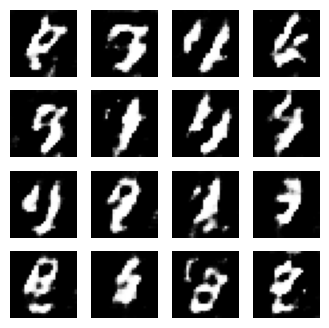

Epoch 11, Gen Loss: 1.0524, Disc Loss: 1.0225, Time: 11.78s


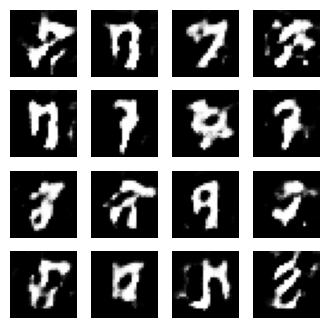

Epoch 12, Gen Loss: 0.9657, Disc Loss: 1.1079, Time: 11.55s


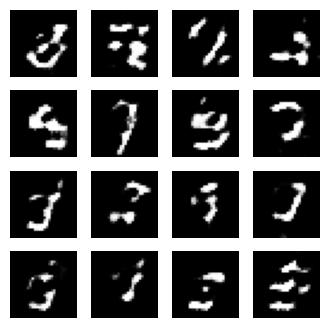

Epoch 13, Gen Loss: 1.0885, Disc Loss: 1.0623, Time: 11.58s


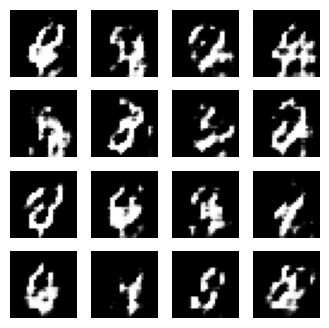

Epoch 14, Gen Loss: 1.0214, Disc Loss: 1.2066, Time: 11.64s


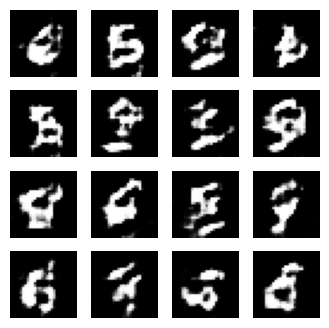

Epoch 15, Gen Loss: 0.9836, Disc Loss: 1.3021, Time: 11.66s


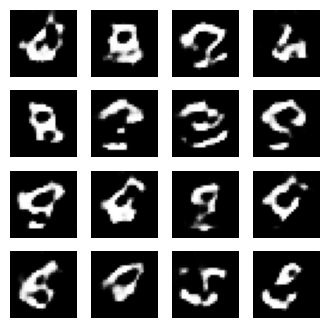

Epoch 16, Gen Loss: 1.2394, Disc Loss: 0.8876, Time: 11.69s


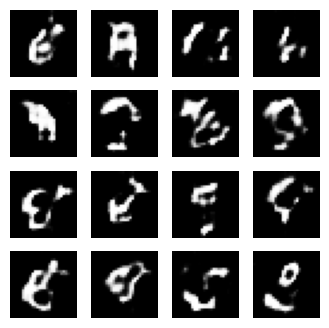

Epoch 17, Gen Loss: 1.1058, Disc Loss: 1.0280, Time: 12.00s


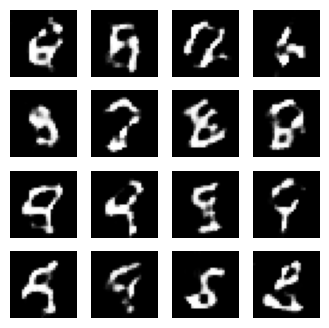

Epoch 18, Gen Loss: 1.1725, Disc Loss: 1.0699, Time: 11.73s


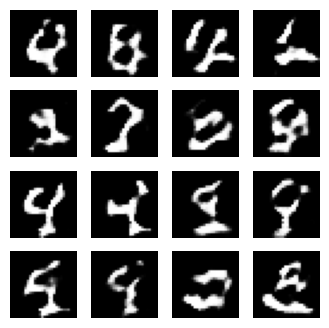

Epoch 19, Gen Loss: 1.3211, Disc Loss: 1.0375, Time: 11.77s


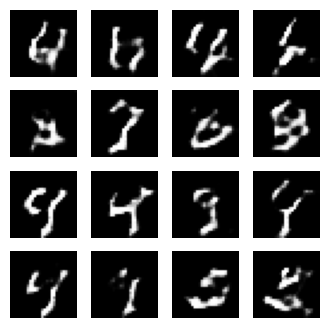

Epoch 20, Gen Loss: 1.3977, Disc Loss: 0.9116, Time: 11.75s


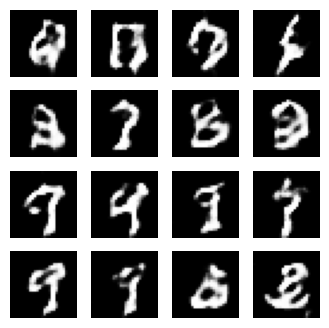

Epoch 21, Gen Loss: 1.1820, Disc Loss: 0.9795, Time: 11.81s


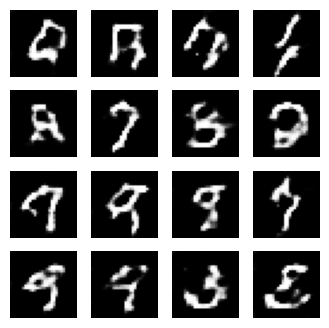

Epoch 22, Gen Loss: 1.1887, Disc Loss: 0.9281, Time: 12.10s


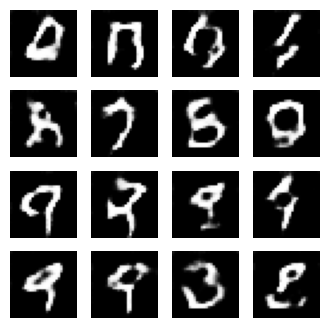

Epoch 23, Gen Loss: 1.1778, Disc Loss: 1.0034, Time: 11.86s


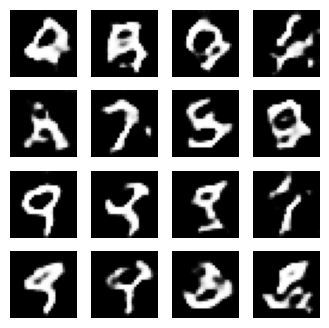

Epoch 24, Gen Loss: 0.9335, Disc Loss: 1.2865, Time: 11.89s


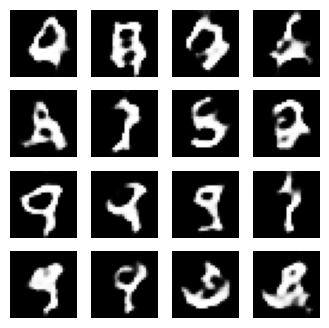

Epoch 25, Gen Loss: 1.2646, Disc Loss: 1.0859, Time: 11.90s


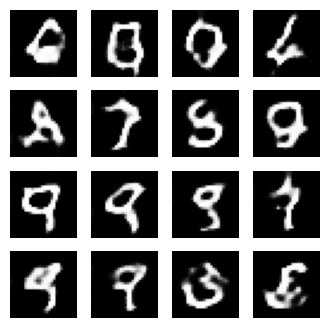

Epoch 26, Gen Loss: 1.0962, Disc Loss: 1.1367, Time: 11.93s


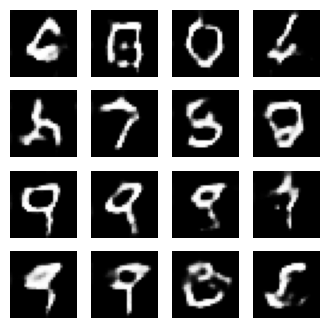

Epoch 27, Gen Loss: 1.0118, Disc Loss: 1.3087, Time: 11.96s


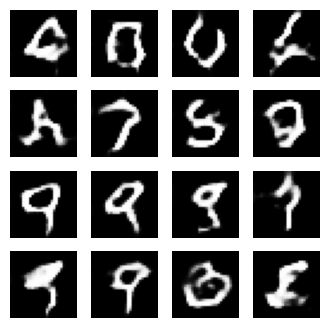

Epoch 28, Gen Loss: 1.0030, Disc Loss: 1.2854, Time: 11.96s


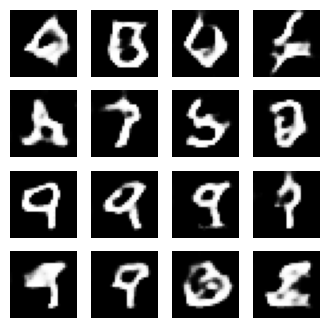

Epoch 29, Gen Loss: 1.0403, Disc Loss: 1.1376, Time: 12.27s


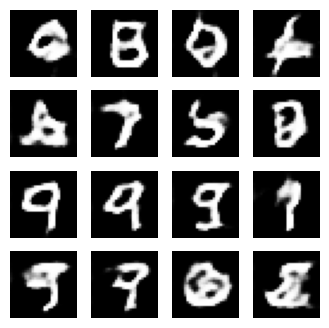

Epoch 30, Gen Loss: 0.8835, Disc Loss: 1.2919, Time: 11.97s


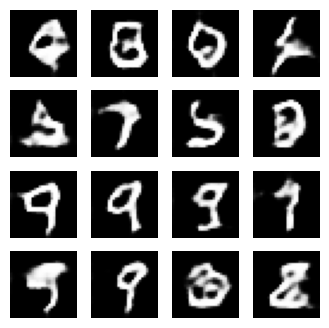

Epoch 31, Gen Loss: 1.0676, Disc Loss: 1.1055, Time: 11.97s


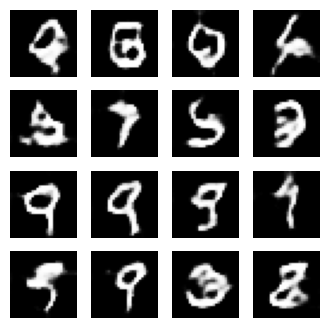

Epoch 32, Gen Loss: 1.0017, Disc Loss: 1.1796, Time: 11.95s


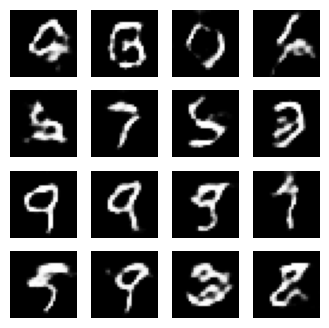

Epoch 33, Gen Loss: 0.9120, Disc Loss: 1.3158, Time: 11.94s


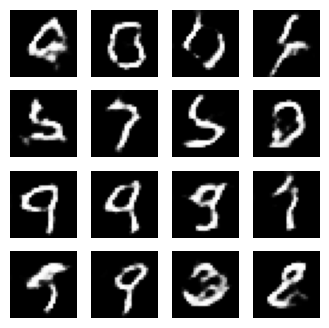

Epoch 34, Gen Loss: 1.1756, Disc Loss: 0.9974, Time: 11.93s


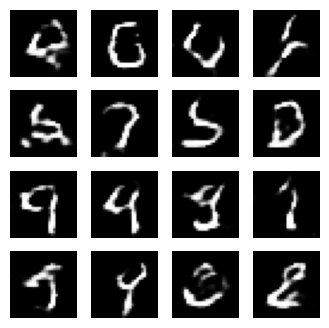

Epoch 35, Gen Loss: 1.0658, Disc Loss: 1.0516, Time: 12.25s


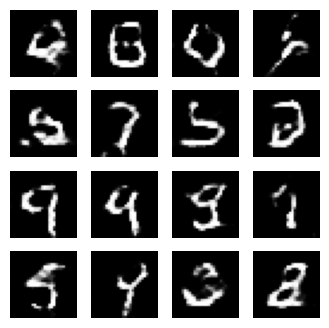

Epoch 36, Gen Loss: 1.2098, Disc Loss: 0.9065, Time: 11.94s


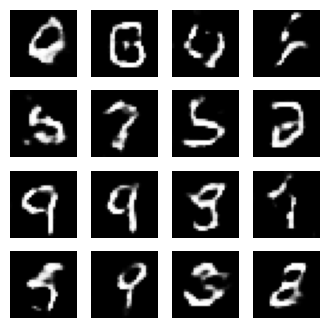

Epoch 37, Gen Loss: 1.1262, Disc Loss: 1.0422, Time: 11.96s


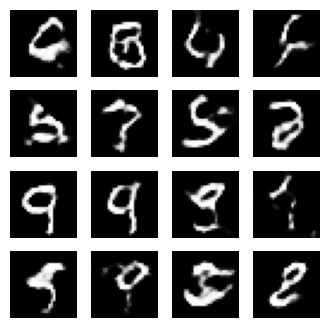

Epoch 38, Gen Loss: 0.9611, Disc Loss: 1.2878, Time: 11.94s


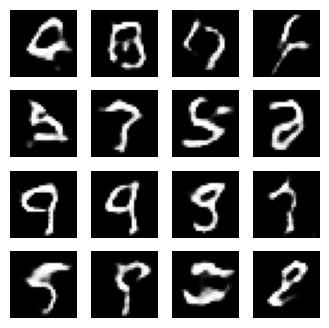

Epoch 39, Gen Loss: 0.9709, Disc Loss: 1.1487, Time: 11.97s


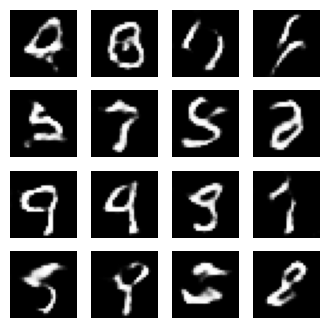

Epoch 40, Gen Loss: 0.9718, Disc Loss: 1.1131, Time: 11.96s


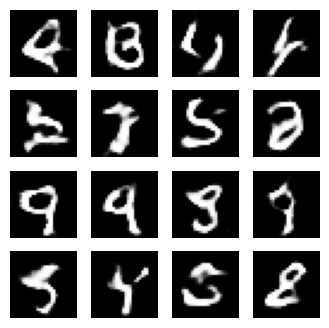

Epoch 41, Gen Loss: 0.9894, Disc Loss: 1.0898, Time: 12.23s


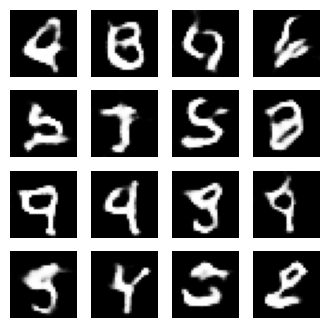

Epoch 42, Gen Loss: 1.2780, Disc Loss: 0.9773, Time: 11.95s


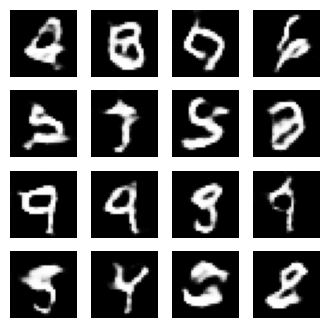

Epoch 43, Gen Loss: 0.9775, Disc Loss: 1.1885, Time: 11.97s


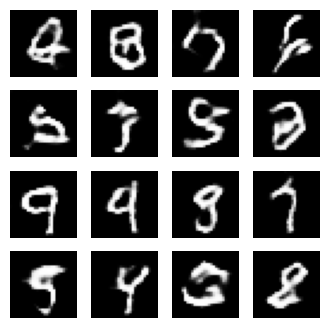

Epoch 44, Gen Loss: 0.8986, Disc Loss: 1.2635, Time: 11.98s


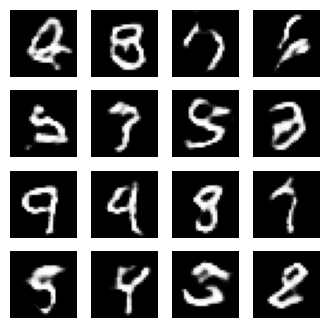

Epoch 45, Gen Loss: 0.9782, Disc Loss: 1.1771, Time: 11.96s


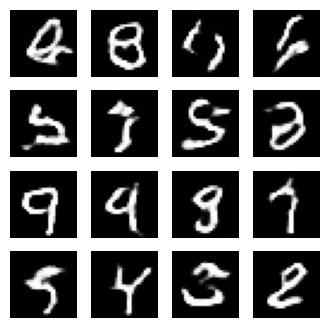

Epoch 46, Gen Loss: 1.0829, Disc Loss: 1.0820, Time: 12.20s


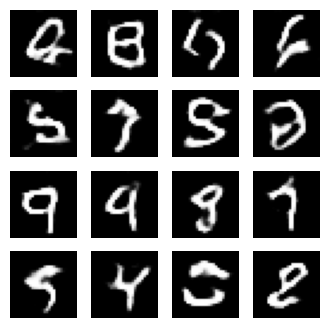

Epoch 47, Gen Loss: 0.7951, Disc Loss: 1.4017, Time: 11.95s


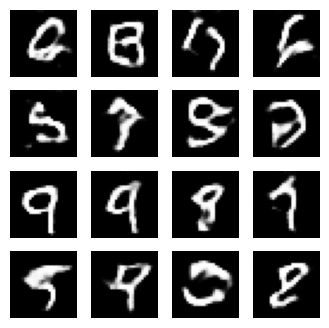

Epoch 48, Gen Loss: 0.9009, Disc Loss: 1.2722, Time: 11.94s


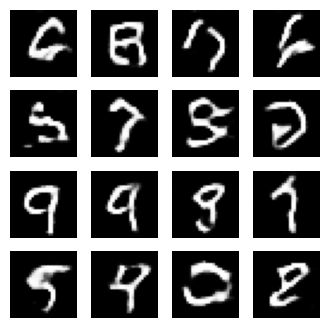

Epoch 49, Gen Loss: 1.0394, Disc Loss: 1.0923, Time: 11.93s


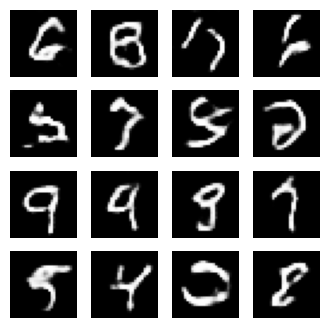

Epoch 50, Gen Loss: 1.0477, Disc Loss: 1.1645, Time: 11.92s


In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Seed for visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        # Generate images every epoch
        generate_and_save_images(generator, epoch + 1, seed)

        print(f'Epoch {epoch+1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}, Time: {time.time()-start:.2f}s')

train(train_dataset, EPOCHS)

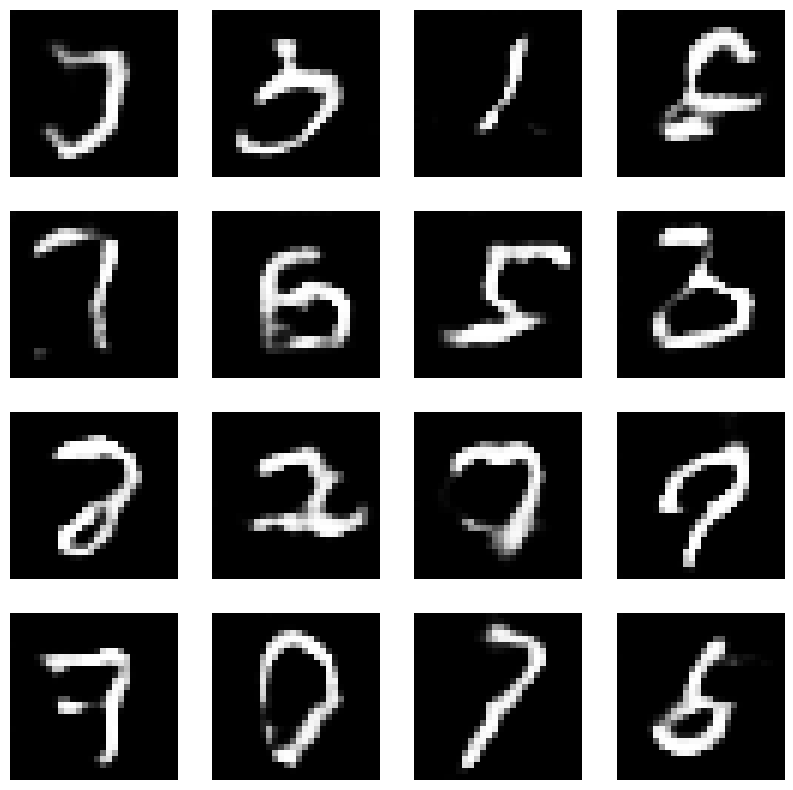

In [ ]:
# Generate new fake digits
def plot_fake_images(n_images=16):
    noise = tf.random.normal([n_images, noise_dim])
    generated_images = generator(noise, training=False)

    plt.figure(figsize=(10,10))
    for i in range(n_images):
        plt.subplot(4,4,i+1)
        plt.imshow(generated_images[i,:,:,0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

plot_fake_images()

In [ ]:
# Save generator
generator.save('mnist_generator.h5')

# To load later:
# generator = tf.keras.models.load_model('mnist_generator.h5')